# Seeded Campaigns Demonstration

In [5]:
import random
import torch
import numpy as np
from tqdm.auto import trange
from tqdm import tqdm

from scipy.optimize import minimize

from botorch.models import SingleTaskGP, MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model, fit_gpytorch_mll
from botorch.optim import optimize_acqf, optimize_acqf_mixed
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.test_functions import Hartmann

from botorch.models.transforms import Standardize
from botorch.models.transforms.input import Normalize

from typing import List
from categorical_hartmann import CategoricalHartmann

from matplotlib import pyplot as plt
plt.style.use('ggplot')

torch.set_default_dtype(torch.float64)

In [6]:
def set_seeds(seed=42):
    """set all library random seeds"""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def random_sampler(n=2, levels=3, dims=3):
    """Randomly sample the design space."""
    set_seeds(120)
    cont = torch.rand(n, dims, dtype=torch.float64)
    cat = torch.randint(0, levels, (n, 1), dtype=torch.float64)
    # cat = torch.tensor(np.arange(0, 11, 1))[:,None]
    sample = torch.concat([cat, cont], dim=-1)
    return sample

SEEDS = np.loadtxt('seeds.txt', delimiter=',', dtype=int)

In [7]:
n_init = 5
n_campaigns = 3
budget = 50-n_init

levels = 5 # number of categories
dims = 6 # number of continuous dimensions
CatHart = CategoricalHartmann(levels=levels, dims=dims, noise_std=0.0, seed=10)
print(CatHart)
X_ = random_sampler(n=n_init, levels=levels, dims=dims)
y_ = CatHart(cat=X_[:,0].to(int), X=X_[:,1:])[:,None]

CategoricalHartmann
    Categories = 5
    Continuous Dims = 6
    LevelIntercepts = [1.0, 3.0, 0.0, 1.5, 2.0]
    LevelSlopes = [1.3947368421052633, 1.0789473684210527, 2.026315789473684, 1.1578947368421053, 1.9473684210526314]
    Optimum: CAT 4 | 8.469874534162251


In [8]:
ensemble_y = np.zeros((n_campaigns, n_init+budget))
ensemble_X = np.zeros((n_campaigns, 7, n_init+budget))
ensemble_acqf = np.zeros((n_campaigns, budget))

for i in (pbar0 := trange(n_campaigns, leave=True, colour="red")):
    set_seeds(SEEDS[i]) # set the random seed for the campaign
    X = X_.clone()
    y = y_.clone()

    # iterate through each trial up to budget - n_initial
    for j in (pbar1 := trange(budget, leave=True)):

        # build the gp model
        gp = MixedSingleTaskGP(
            train_X=X,
            train_Y=y,
            cat_dims=[0],
            input_transform = Normalize(d=X.shape[-1], indices=list(np.arange(0, dims, 1)+1)),
            outcome_transform = Standardize(m=y.shape[-1]),
        )

        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)

        bounds = torch.stack([torch.zeros(dims+1), torch.ones(dims+1)])
        bounds[0,0] = 0.0
        bounds[1,0] = float(levels-1)

        X_new, acq_value = optimize_acqf_mixed(
            acq_function = UpperConfidenceBound(gp, beta=2),
            bounds=bounds,
            fixed_features_list=[{0:i} for i in range(levels)],
            q=1,
            num_restarts=20,
            raw_samples=250,
        )

        X = torch.cat([X, X_new])
        y = torch.cat([y, CatHart(cat=X_new[:,0].to(int), X=X_new[:,1:])[:,None]])

        pbar0.set_description(f"Processing Trial {j+1} of Campaign {i+1}")
        pbar1.set_description(f"Campaign {i+1} | Best Value {round(torch.max(y).item(),3)}")

    ensemble_y[i,:] = y.flatten()
    ensemble_X[i,:,:] = X.T

Campaign 1 | Best Value 8.463: 100%|██████████| 45/45 [01:29<00:00,  1.99s/it]/s]
Processing Trial 1 of Campaign 2:  33%|███▎      | 1/3 [01:30<02:58, 89.37s/it] /Users/andrewf/miniconda3/envs/take_your_time/lib/python3.9/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/Users/andrewf/miniconda3/envs/take_your_time/lib/python3.9/site-packages/botorch/optim/initializers.py:432: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
Campaign 2 | Best Value 6.584: 100%|██████████| 45/45 [01:31<00:00,  2.04s/it] 89.37s/it]
Campaign 3 | Best Value 8.47: 100%|██████████| 45/45 [01:05<00:00,  1.46s/it], 90.67s/it]
Processing Trial 45 of Campaign 3: 100%|██████████| 3/3 [04:06<00:00, 82.21s/it]


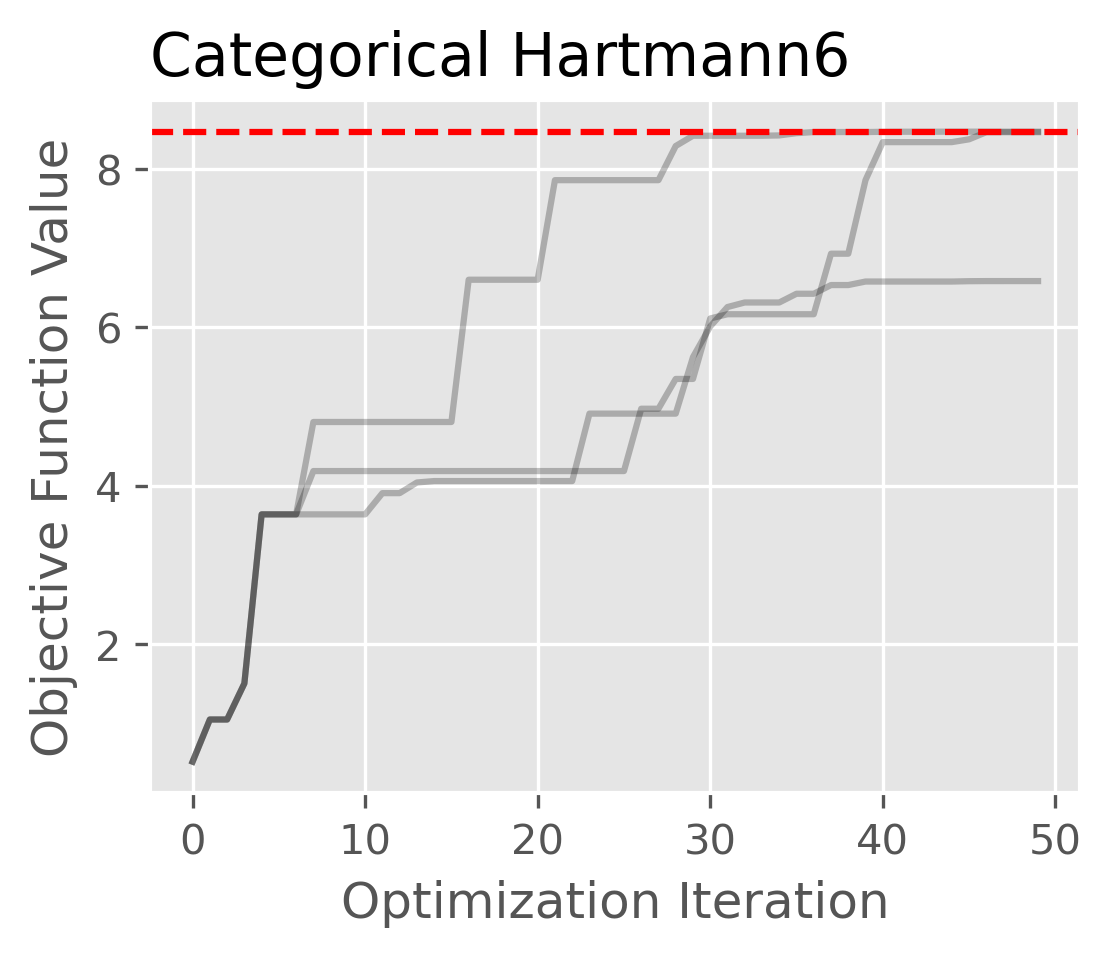

In [12]:
best_to_trial = np.maximum.accumulate(ensemble_y, axis=1)
fig, ax = plt.subplots(figsize=(4,3), dpi=300)
plt.plot(best_to_trial.T, color='black', alpha=0.25, label='trials')
plt.axhline(torch.max(CatHart.optima).item(), color='red', ls='--', label='optimal')
plt.xlabel('Optimization Iteration')
plt.ylabel('Objective Function Value')
plt.title('Categorical Hartmann6', loc='left')
plt.show()